Hong Fei Jin<br>
INSY 695 – Enterprise Data Science & ML in Production I<br>
Fatih Nayebi<br>
Sunday, February 12, 2023

# Assignment 2

## Preparing the Data (See Assignment 1)

In [1]:
# Import the data
import pandas as pd
df = pd.read_csv('SeoulBikeData.csv', encoding = 'mbcs')

In [2]:
# Get the weekday using the 'datetime' package
import numpy as np
from datetime import datetime

# Create empty column
df['Weekday'] = np.NaN

# Fill in weekdays
for i in range(len(df)):
    date = str(df['Date'][i])
    date_obj = datetime.strptime(date, '%d/%m/%Y').date()
    df['Weekday'][i] = date_obj.weekday()

C:\Users\jinho\AppData\Local\Temp\ipykernel_6276\609755345.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weekday'][i] = date_obj.weekday()


In [3]:
# Split 'Date' into 'Day', 'Month', and 'Year'
df[['Day', 'Month', 'Year']] = df['Date'].str.split('/', expand = True)
df[['Day', 'Month', 'Year', 'Weekday']] = df[['Day', 'Month', 'Year', 'Weekday']].astype('int')

In [4]:
# Reorder columns for the sake of better visibility
cols = df.columns.tolist()
cols = cols[0:1] + cols[-4:] + cols[1:-4]
df = df[cols]

In [5]:
df = df[(df['Rainfall(mm)'] <= 2.5)]
df = df[(df['Snowfall (cm)'] <= 2.2)]
df = df[(df['Solar Radiation (MJ/m2)'] <= 2.33)]
df = df[(df['Wind speed (m/s)'] <= 4.4)]
df.shape

(7793, 18)

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 119)
print('Training set:', len(train_set))
print('Testing set:', len(test_set))

Training set: 6234
Testing set: 1559


In [7]:
bike = train_set.drop(['Rented Bike Count', 'Date', 'Dew point temperature(°C)'], axis = 1)
bike_labels = train_set['Rented Bike Count'].copy()
bike

,Weekday,Day,Month,Year,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
100,1,5,12,2017,4,-7.2,34,3.0,2000,0.00,0.0,0.0,Winter,No Holiday,Yes
8486,0,19,11,2018,14,10.6,34,2.8,920,1.07,0.0,0.0,Autumn,No Holiday,Yes
4337,2,30,5,2018,17,24.1,41,2.2,1980,1.90,0.0,0.0,Spring,No Holiday,Yes
4700,3,14,6,2018,20,22.6,74,1.2,1594,0.01,0.0,0.0,Summer,No Holiday,Yes
7192,2,26,9,2018,16,24.4,35,1.8,2000,1.71,0.0,0.0,Autumn,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7197,2,26,9,2018,21,18.9,43,2.0,2000,0.00,0.0,0.0,Autumn,No Holiday,Yes
26,5,2,12,2017,2,-2.9,86,1.5,1256,0.00,0.0,0.0,Winter,No Holiday,Yes
8525,2,21,11,2018,5,6.8,86,0.5,692,0.00,0.0,0.0,Autumn,No Holiday,Yes
2658,2,21,3,2018,18,2.0,77,1.3,2000,0.07,0.0,0.0,Spring,No Holiday,Yes


In [8]:
bike_num = bike.select_dtypes(include = [np.number])
bike_cat = bike[['Seasons', 'Holiday', 'Functioning Day']]

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipeline = make_pipeline(SimpleImputer(strategy = 'median'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent'), 
                             OneHotEncoder(handle_unknown = 'ignore'))

In [10]:
bike_num_clean = num_pipeline.fit_transform(bike_num)
bike_num_clean = pd.DataFrame(bike_num_clean, columns = list(bike_num.columns))

bike_cat_labels = ['Autumn', 'Spring', 'Summer', 'Winter', 'Holiday', 'No Holiday', 'No', 'Yes']
bike_cat_clean = cat_pipeline.fit_transform(bike_cat)
bike_cat_clean = pd.DataFrame(bike_cat_clean.toarray(), columns = bike_cat_labels)

In [11]:
bike_cleaned = pd.concat([bike_num_clean, bike_cat_clean], axis = 1, join = 'inner')
bike_cleaned = bike_cleaned.drop(['Autumn', 'No Holiday', 'No'], axis = 1)
bike_cleaned

,Weekday,Day,Month,Year,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Spring,Summer,Winter,Holiday,Yes
0,-1.006173,-1.207988,1.563015,-3.234124,-1.011668,-1.641680,-1.291095,1.452268,0.919984,-0.626638,-0.177791,-0.172022,0.0,0.0,1.0,0.0,1.0
1,-1.508292,0.380434,1.277657,0.309203,0.372269,-0.136938,-1.291095,1.241153,-0.855277,1.058043,-0.177791,-0.172022,0.0,0.0,0.0,0.0,1.0
2,-0.504053,1.628480,-0.434491,0.309203,0.787450,1.004299,-0.933634,0.607810,0.887108,2.364852,-0.177791,-0.172022,1.0,0.0,0.0,0.0,1.0
3,-0.001933,-0.186859,-0.149133,0.309203,1.202631,0.877495,0.751537,-0.447763,0.252617,-0.610893,-0.177791,-0.172022,0.0,1.0,0.0,0.0,1.0
4,-0.504053,1.174645,0.706941,0.309203,0.649056,1.029660,-1.240029,0.185580,0.919984,2.065703,-0.177791,-0.172022,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,-0.504053,1.174645,0.706941,0.309203,1.341024,0.564711,-0.831502,0.396695,0.919984,-0.626638,-0.177791,-0.172022,0.0,0.0,0.0,0.0,1.0
6230,1.002306,-1.548364,1.563015,-3.234124,-1.288455,-1.278175,1.364327,-0.131092,-0.302974,-0.626638,-0.177791,-0.172022,0.0,0.0,1.0,0.0,1.0
6231,-0.504053,0.607352,1.277657,0.309203,-0.873274,-0.458175,1.364327,-1.186665,-1.230055,-0.626638,-0.177791,-0.172022,0.0,0.0,0.0,0.0,1.0
6232,-0.504053,0.607352,-1.005207,0.309203,0.925843,-0.863948,0.904734,-0.342206,0.919984,-0.516425,-0.177791,-0.172022,1.0,0.0,0.0,0.0,1.0


## Calculate Average Treatment Effect (ATE)

In [12]:
# Import libraries
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [13]:
# Set target, control feautres, and treatment features
X = bike_cleaned.drop('Holiday', axis = 1)
feature_names = X.columns
y = bike_labels
treatment = bike_cleaned['Holiday']

In [14]:
# LRSRegressor
lsr = LRSRegressor()
ate_lsr = lsr.estimate_ate(X = X, treatment = treatment, y = y)
print('Linear Regression:')
print('ATE estimate: {:.03f}'.format(ate_lsr[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_lsr[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_lsr[2][0]))

Linear Regression:
ATE estimate: -118.277
ATE lower bound: -161.186
ATE upper bound: -75.368


In [15]:
# XGBTRegressor
xgbt = XGBTRegressor()
ate_xgbt = xgbt.estimate_ate(X = X, treatment = treatment, y = y)
print('Using the ready-to-use XGBTRegressor class:')
print('ATE estimate: {:.03f}'.format(ate_xgbt[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_xgbt[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_xgbt[2][0]))

Using the ready-to-use XGBTRegressor class:
ATE estimate: -185.013
ATE lower bound: -196.165
ATE upper bound: -173.862


In [16]:
# BaseXRegressor & XGBRegressor
bx_xbgt = BaseXRegressor(XGBRegressor())
ate_bx_xbgt = bx_xbgt.estimate_ate(X = X, treatment = treatment, y = y)
print('BaseXRegressor & XGBRegressor:')
print('ATE estimate: {:.03f}'.format(ate_bx_xbgt[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_bx_xbgt[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_bx_xbgt[2][0]))

# BaseXRegressor & LinearRegression
bx_lr = BaseXRegressor(learner = LinearRegression())
ate_bx_lr = bx_lr.estimate_ate(X = X, treatment = treatment, y = y)
print('\nBaseXRegressor & LinearRegression:')
print('ATE estimate: {:.03f}'.format(ate_bx_lr[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_bx_lr[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_bx_lr[2][0]))

BaseXRegressor & XGBRegressor:
ATE estimate: -162.762
ATE lower bound: -169.548
ATE upper bound: -155.977

BaseXRegressor & LinearRegression:
ATE estimate: -174.324
ATE lower bound: -210.694
ATE upper bound: -137.954


In [17]:
# BaseRRegressor & XGBRegressor
br_xbgt = BaseRRegressor(XGBRegressor())
ate_br_xbgt = br_xbgt.estimate_ate(X = X, treatment = treatment, y = y)
print('BaseRRegressor & XGBRegressor:')
print('ATE estimate: {:.03f}'.format(ate_br_xbgt[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_br_xbgt[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_br_xbgt[2][0]))

# BaseRRegressor & LinearRegression
br_lr = BaseRRegressor(learner = LinearRegression())
ate_br_lr = br_lr.estimate_ate(X = X, treatment = treatment, y = y)
print('\nBaseRRegressor & LinearRegression:')
print('ATE estimate: {:.03f}'.format(ate_br_lr[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_br_lr[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_br_lr[2][0]))

BaseRRegressor & XGBRegressor:
ATE estimate: -85.891
ATE lower bound: -86.304
ATE upper bound: -85.478

BaseRRegressor & LinearRegression:
ATE estimate: -195.292
ATE lower bound: -195.828
ATE upper bound: -194.756


## Calculate Individual Treatment Effect (ITE/CATE)

In [18]:
cate_lsr = lsr.fit_predict(X = X, treatment = treatment, y = y)
cate_xgbt = xgbt.fit_predict(X = X, treatment = treatment, y = y)
cate_bx_xbgt = bx_xbgt.fit_predict(X = X, treatment = treatment, y = y)
cate_bx_lr = bx_lr.fit_predict(X = X, treatment = treatment, y = y)
cate_br_xbgt = br_xbgt.fit_predict(X = X, treatment = treatment, y = y)
cate_br_lr = br_lr.fit_predict(X = X, treatment = treatment, y = y)

## Feature Importance

In [19]:
# Change treatment from 0 & 1 to 'Holiday' & 'control'
multi_treatment = np.array(['Holiday' if x == 1 else 'control' for x in treatment])

# Choose a base algorithm
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

### BaseSRegressor

{'Holiday': Hour                       0.530344
Solar Radiation (MJ/m2)    0.150118
Weekday                    0.114532
Temperature(°C)            0.060298
Month                      0.035458
Humidity(%)                0.034582
Yes                        0.030554
Winter                     0.017327
Day                        0.014395
Rainfall(mm)               0.005048
Visibility (10m)           0.004661
Wind speed (m/s)           0.001566
Summer                     0.000871
Spring                     0.000170
Snowfall (cm)              0.000077
Year                       0.000000
dtype: float64}


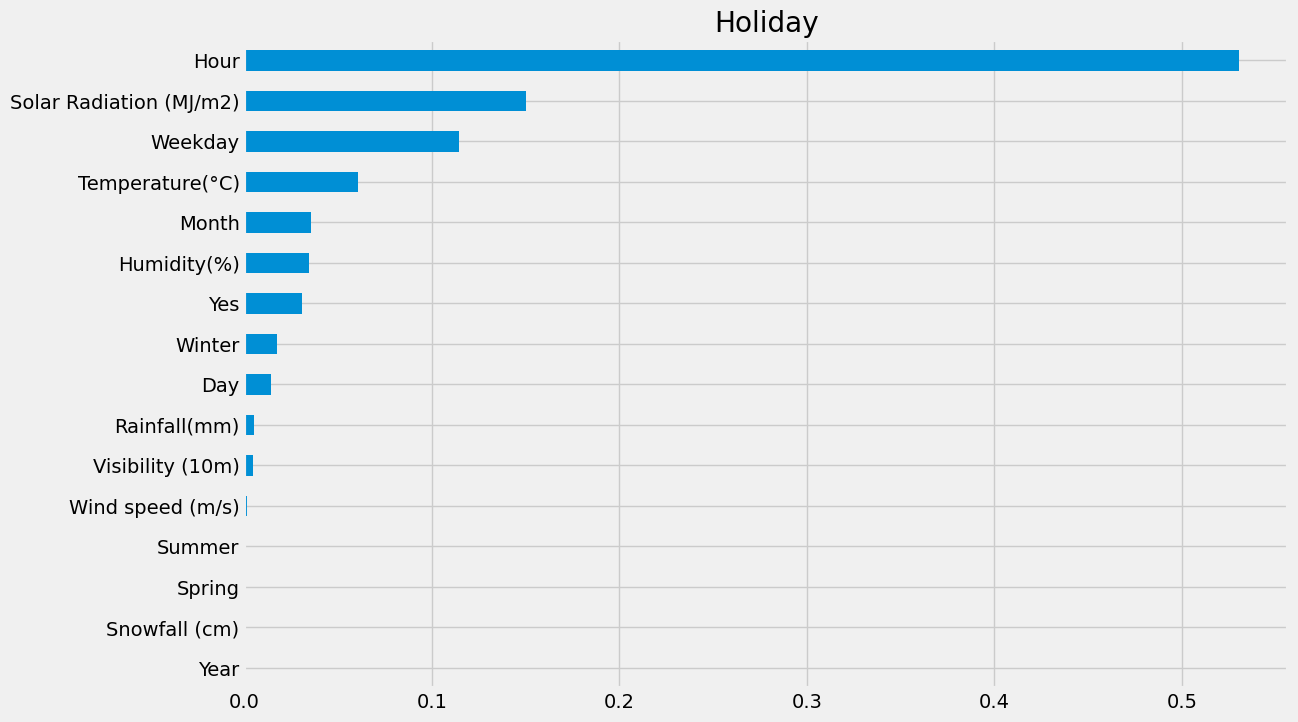

In [20]:
slearner = BaseSRegressor(base_algo, control_name = 'control')
slearner.estimate_ate(X, multi_treatment, y)
slearner_tau = slearner.fit_predict(X, multi_treatment, y)
print(slearner.get_importance(X = X, tau = slearner_tau, normalize = True, 
                        method = 'auto', features = feature_names))
slearner.plot_importance(X = X, tau = slearner_tau, normalize = True, 
                         method = 'auto', features = feature_names)

{'Holiday': Hour                       1.531113
Weekday                    0.275150
Solar Radiation (MJ/m2)    0.267107
Temperature(°C)            0.131237
Yes                        0.107874
Month                      0.073780
Humidity(%)                0.070309
Day                        0.028122
Winter                     0.014838
Visibility (10m)           0.005531
Rainfall(mm)               0.005167
Wind speed (m/s)           0.002125
Spring                     0.000353
Summer                     0.000202
Snowfall (cm)              0.000077
Year                       0.000000
dtype: float64}


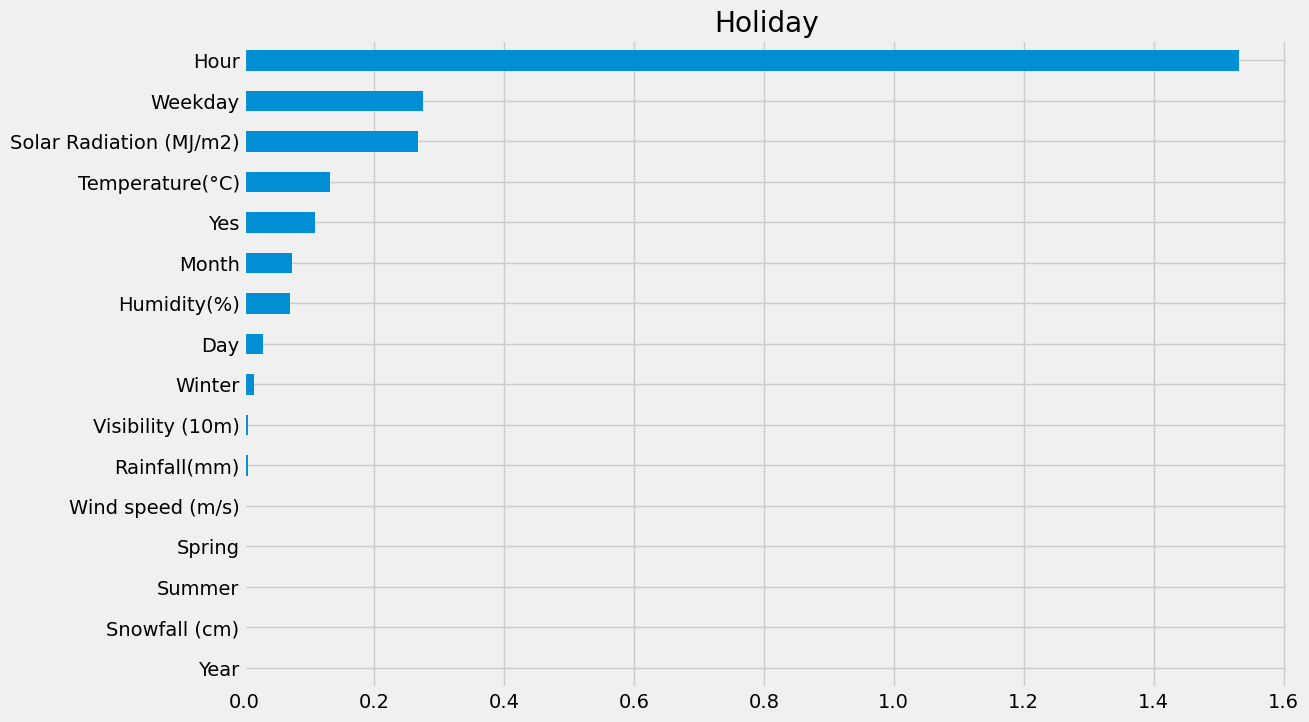

In [21]:
print(slearner.get_importance(X = X, tau = slearner_tau, method = 'permutation', 
                        features = feature_names, random_state = 119))
slearner.plot_importance(X = X, tau = slearner_tau, method = 'permutation', 
                         features = feature_names, random_state = 119)

[20.37405054 11.86062633 15.27968093  0.         92.32323978 20.40658499
 16.72592082  1.92646578  3.76581623 19.16186149  2.93116882  0.12440951
  0.3161975   0.706377    8.5927378   8.36128142]


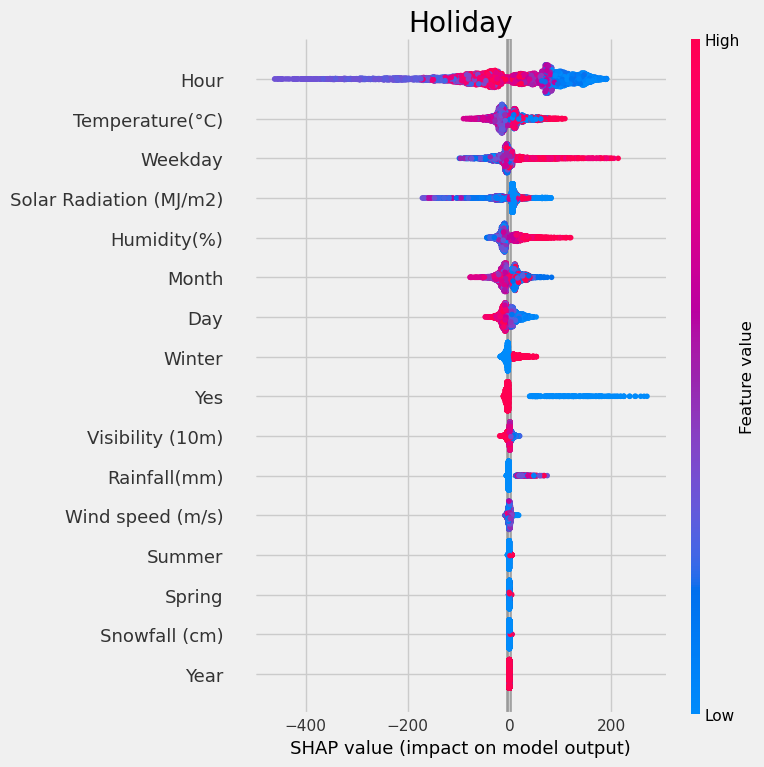

In [22]:
shap_slearner = slearner.get_shap_values(X = X, tau = slearner_tau)
print(np.mean(np.abs(shap_slearner['Holiday']), axis = 0))
slearner.plot_shap_values(X = X, tau = slearner_tau, features = feature_names)

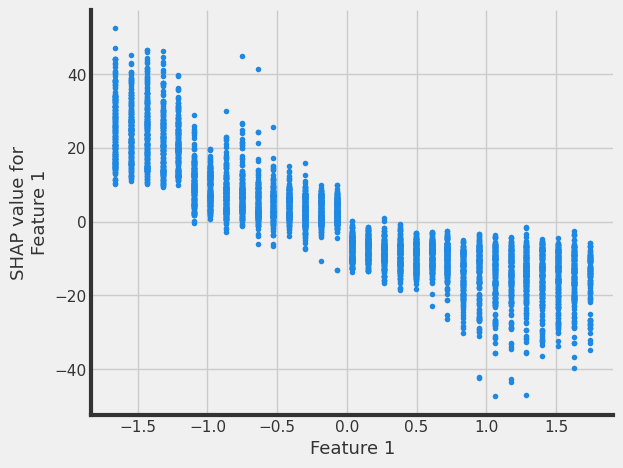

In [23]:
slearner.plot_shap_dependence(treatment_group = 'Holiday', feature_idx = 1, X = X, tau = slearner_tau,
                              interaction_idx = None, shap_dict = shap_slearner)

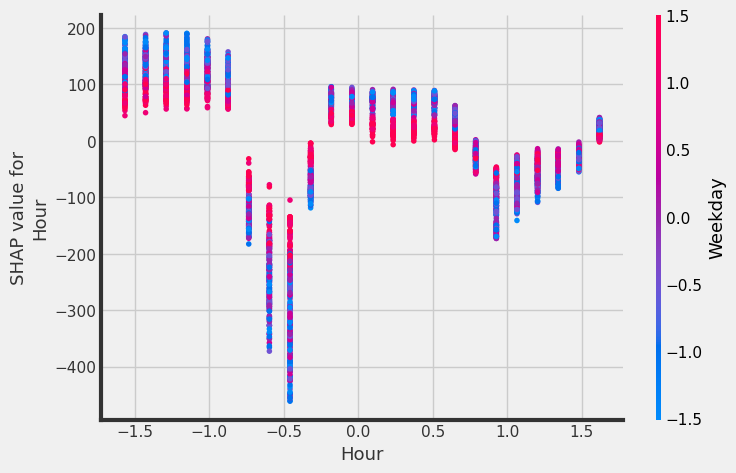

In [24]:
# Search for feature with greatest approximate interaction
slearner.plot_shap_dependence(treatment_group = 'Holiday', feature_idx = 'Hour', X = X,
                              tau = slearner_tau, interaction_idx = 'auto',
                              shap_dict = shap_slearner, features = feature_names)

### BaseTRegressor

{'Holiday': Hour                       0.268733
Temperature(°C)            0.244841
Day                        0.089232
Yes                        0.083128
Month                      0.058971
Weekday                    0.055904
Winter                     0.053235
Rainfall(mm)               0.046149
Humidity(%)                0.045928
Solar Radiation (MJ/m2)    0.037946
Wind speed (m/s)           0.007746
Visibility (10m)           0.005911
Summer                     0.001543
Spring                     0.000450
Snowfall (cm)              0.000284
Year                       0.000000
dtype: float64}


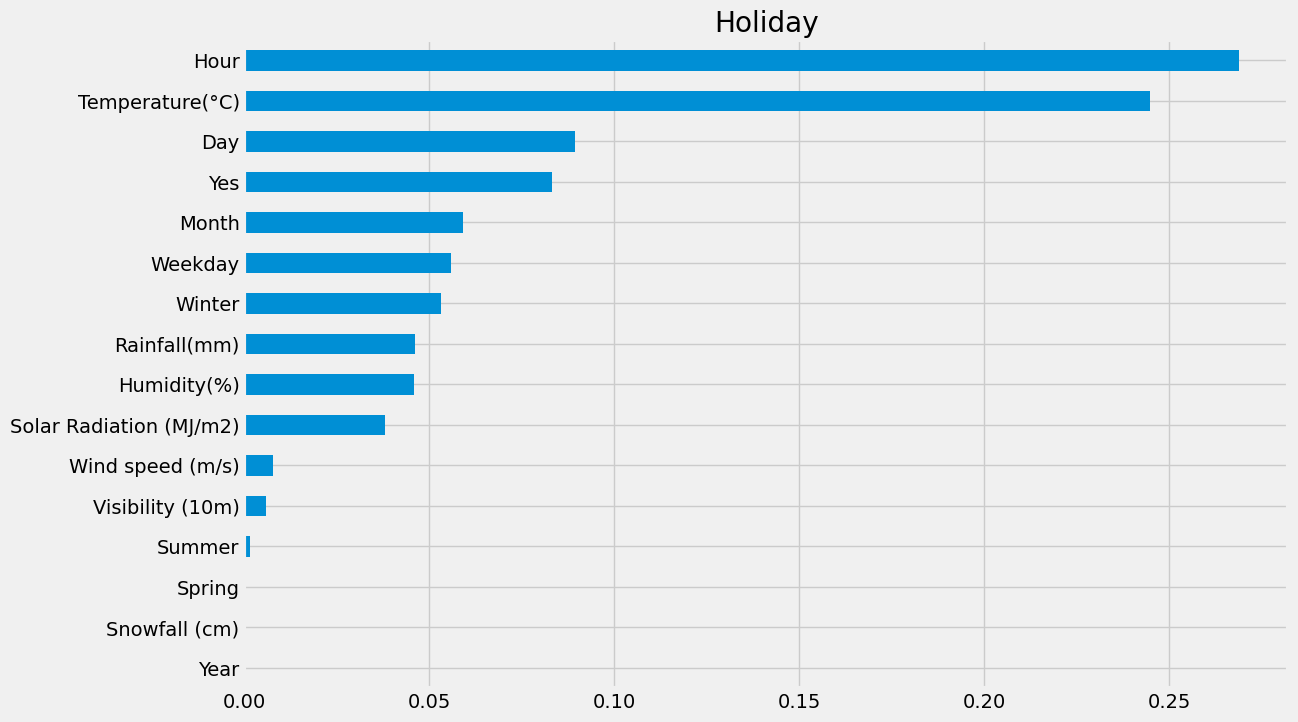

In [25]:
tlearner = BaseTRegressor(base_algo, control_name = 'control')
tlearner.estimate_ate(X, multi_treatment, y)
tlearner_tau = tlearner.fit_predict(X, multi_treatment, y)
print(tlearner.get_importance(X = X, tau = tlearner_tau, normalize = True, 
                        method = 'auto', features = feature_names))
tlearner.plot_importance(X = X, tau = tlearner_tau, normalize = True, 
                         method = 'auto', features = feature_names)

{'Holiday': Hour                       0.700597
Temperature(°C)            0.629344
Yes                        0.310611
Day                        0.185688
Weekday                    0.155926
Month                      0.097251
Winter                     0.090869
Humidity(%)                0.086541
Solar Radiation (MJ/m2)    0.070599
Rainfall(mm)               0.057850
Wind speed (m/s)           0.010589
Visibility (10m)           0.006634
Summer                     0.002145
Spring                     0.000407
Snowfall (cm)              0.000369
Year                       0.000000
dtype: float64}


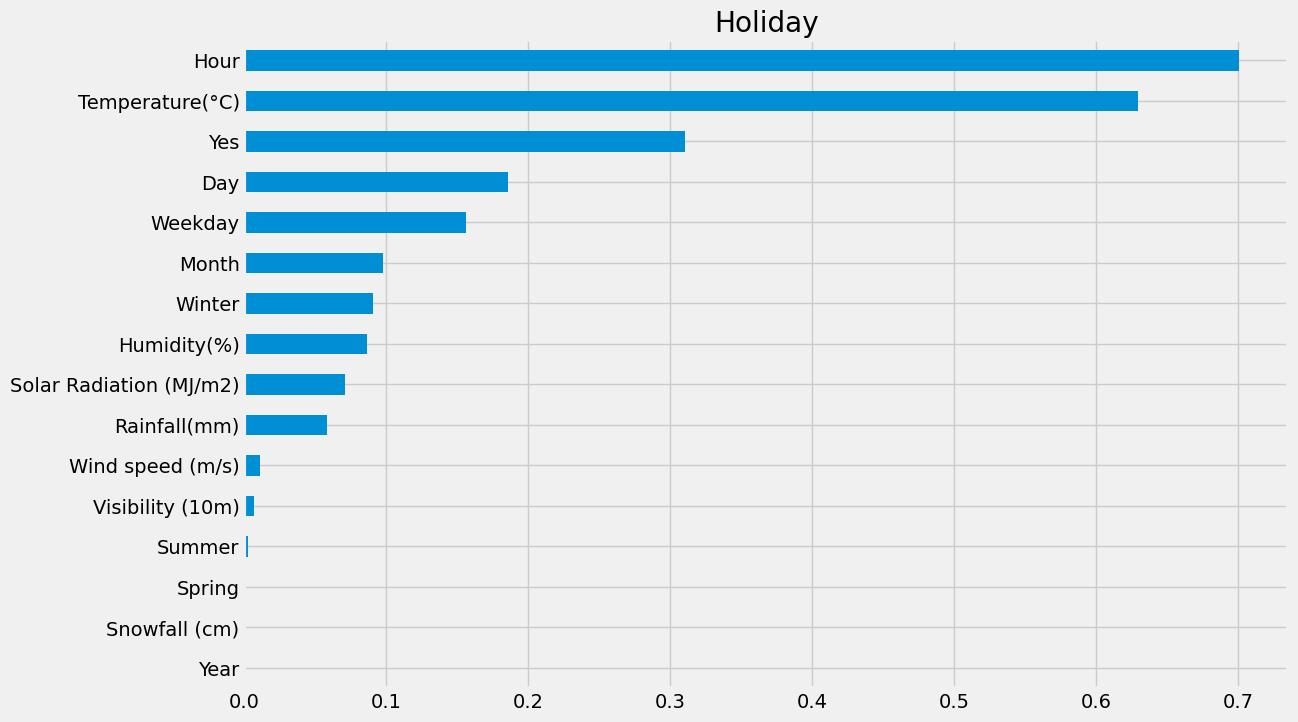

In [26]:
print(tlearner.get_importance(X = X, tau = tlearner_tau, method = 'permutation', 
                        features = feature_names, random_state = 119))
tlearner.plot_importance(X = X, tau = tlearner_tau, method = 'permutation', 
                         features = feature_names, random_state = 119)

[ 42.93917524 108.8475986   55.57948885   0.         174.69748994
 188.99323677  29.98802638  13.24254353   8.80409523  38.93270823
  28.06269488   1.83042943   2.43153104   4.19043466  62.85863726
  48.65131975]


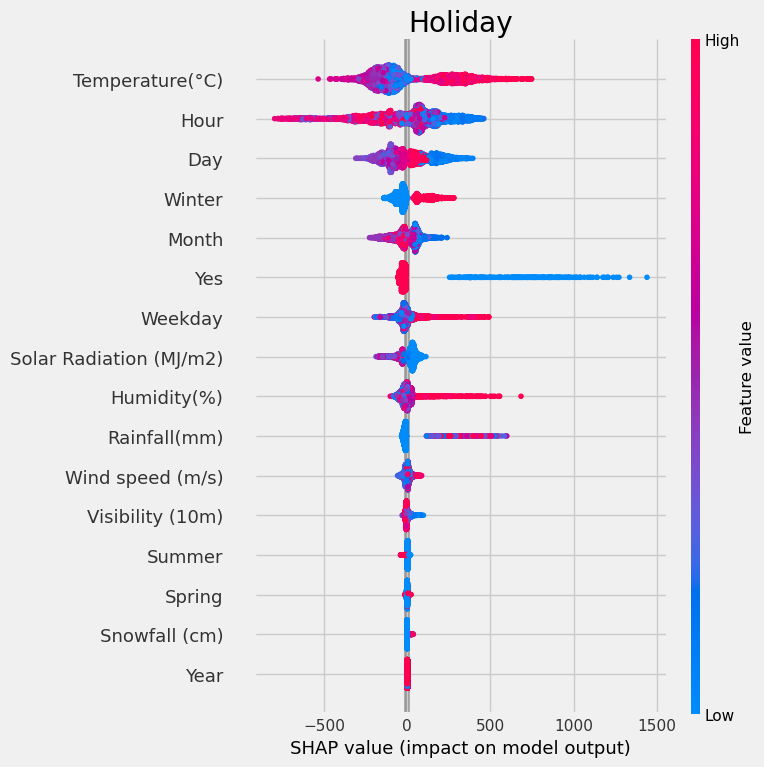

In [27]:
shap_tlearner = tlearner.get_shap_values(X = X, tau = tlearner_tau)
print(np.mean(np.abs(shap_tlearner['Holiday']), axis = 0))
tlearner.plot_shap_values(X = X, tau = tlearner_tau, features = feature_names)

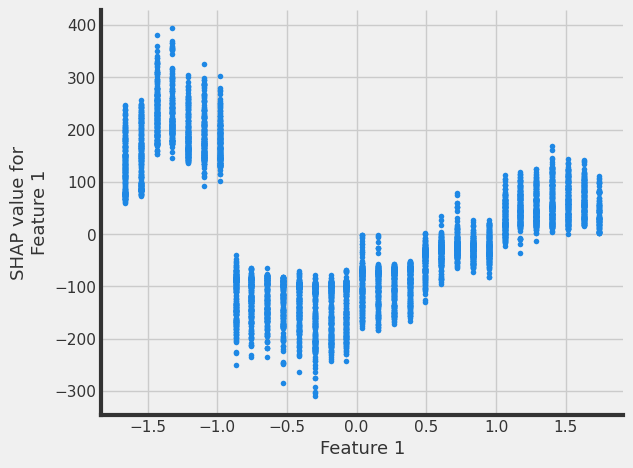

In [28]:
tlearner.plot_shap_dependence(treatment_group = 'Holiday', feature_idx = 1, X = X, tau = tlearner_tau,
                              interaction_idx = None, shap_dict = shap_tlearner)

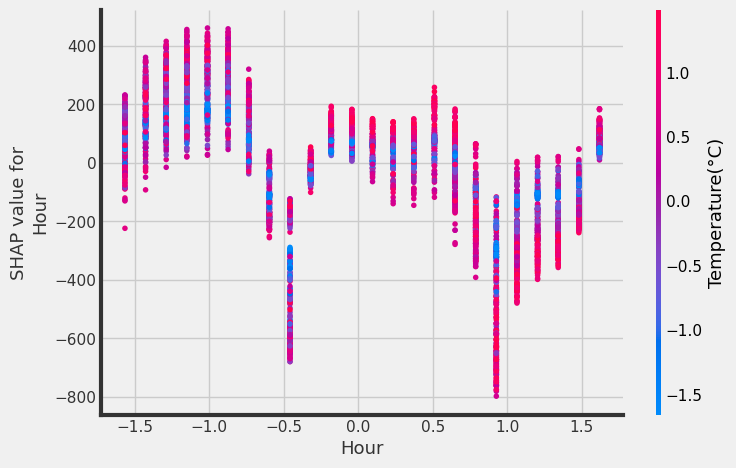

In [29]:
# Search for feature with greatest approximate interaction
tlearner.plot_shap_dependence(treatment_group = 'Holiday', feature_idx = 'Hour', X = X,
                              tau = tlearner_tau, interaction_idx = 'auto',
                              shap_dict = shap_tlearner, features = feature_names)

### BaseXRegressor

{'Holiday': Hour                       0.469669
Solar Radiation (MJ/m2)    0.208170
Day                        0.107691
Month                      0.069574
Temperature(°C)            0.056728
Weekday                    0.041766
Humidity(%)                0.013103
Summer                     0.010194
Visibility (10m)           0.009625
Wind speed (m/s)           0.007055
Yes                        0.004547
Spring                     0.001094
Winter                     0.000670
Rainfall(mm)               0.000069
Snowfall (cm)              0.000046
Year                       0.000000
dtype: float64}


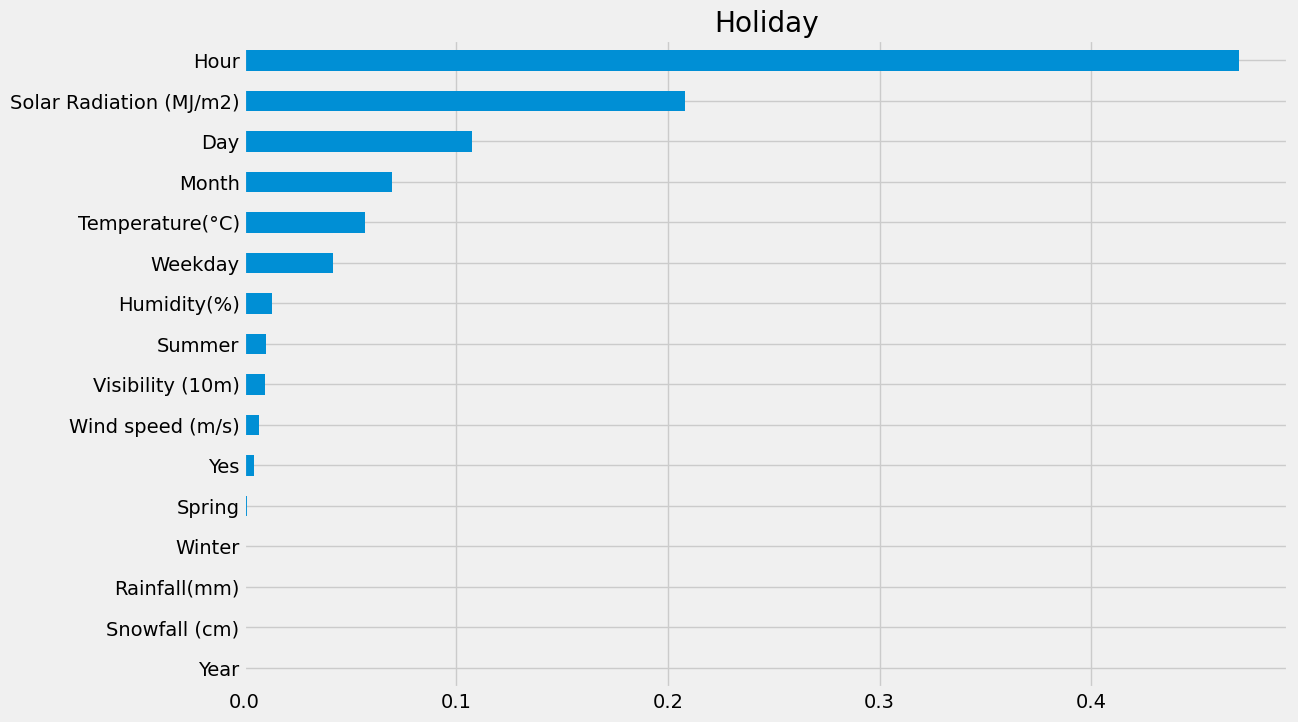

In [30]:
xlearner = BaseXRegressor(base_algo, control_name = 'control')
xlearner.estimate_ate(X, multi_treatment, y)
xlearner_tau = xlearner.fit_predict(X, multi_treatment, y)
print(xlearner.get_importance(X = X, tau = xlearner_tau, normalize = True, 
                        method = 'auto', features = feature_names))
xlearner.plot_importance(X = X, tau = xlearner_tau, normalize = True, 
                         method = 'auto', features = feature_names)

{'Holiday': Hour                       1.054164
Solar Radiation (MJ/m2)    0.402943
Day                        0.220745
Month                      0.102436
Weekday                    0.078203
Temperature(°C)            0.073857
Summer                     0.026429
Humidity(%)                0.017973
Visibility (10m)           0.016888
Wind speed (m/s)           0.011718
Yes                        0.011677
Spring                     0.000861
Winter                     0.000841
Rainfall(mm)               0.000032
Snowfall (cm)              0.000009
Year                       0.000000
dtype: float64}


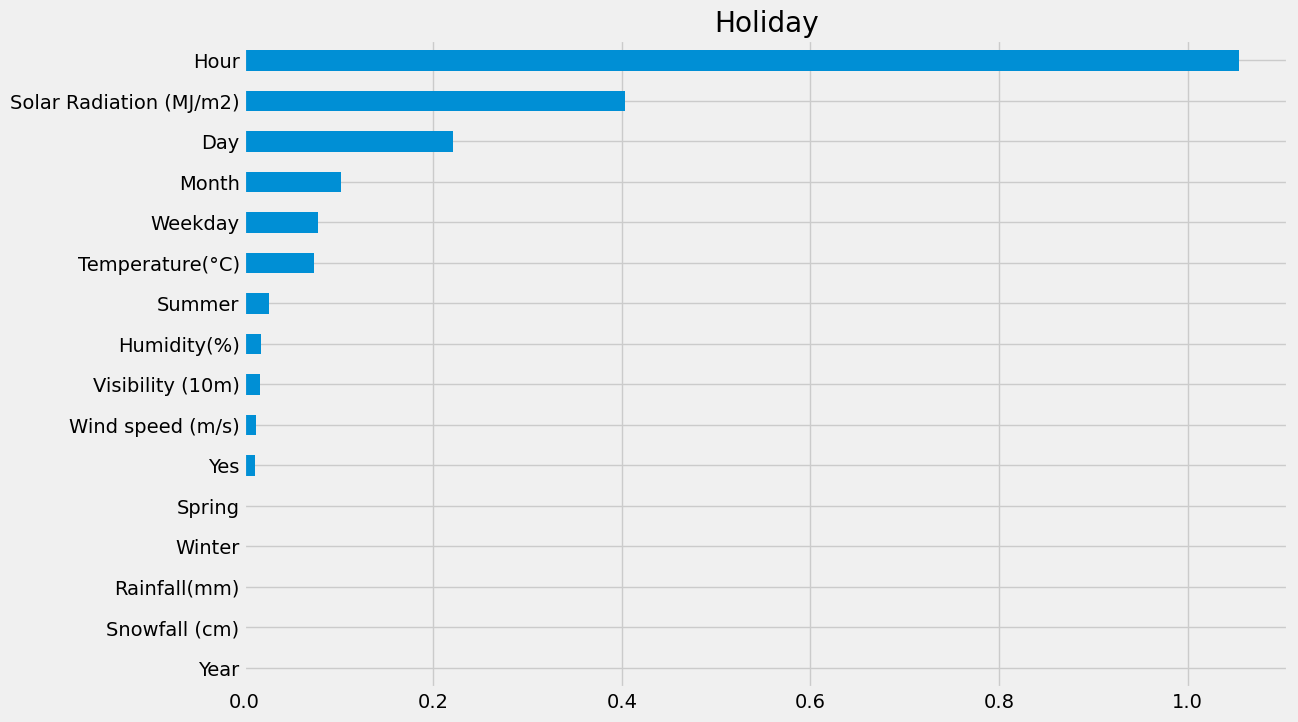

In [31]:
print(xlearner.get_importance(X = X, tau = xlearner_tau, method = 'permutation', 
                        features = feature_names, random_state = 119))
xlearner.plot_importance(X = X, tau = xlearner_tau, method = 'permutation', 
                         features = feature_names, random_state = 119)

[2.40737519e+01 5.64195434e+01 3.69343748e+01 0.00000000e+00
 1.16812552e+02 1.67325481e+01 1.01225434e+01 7.12260453e+00
 8.16048170e+00 5.07356294e+01 5.36449593e-01 8.78674263e-02
 1.65823413e+00 1.22390487e+01 2.25329102e+00 4.44720888e+00]


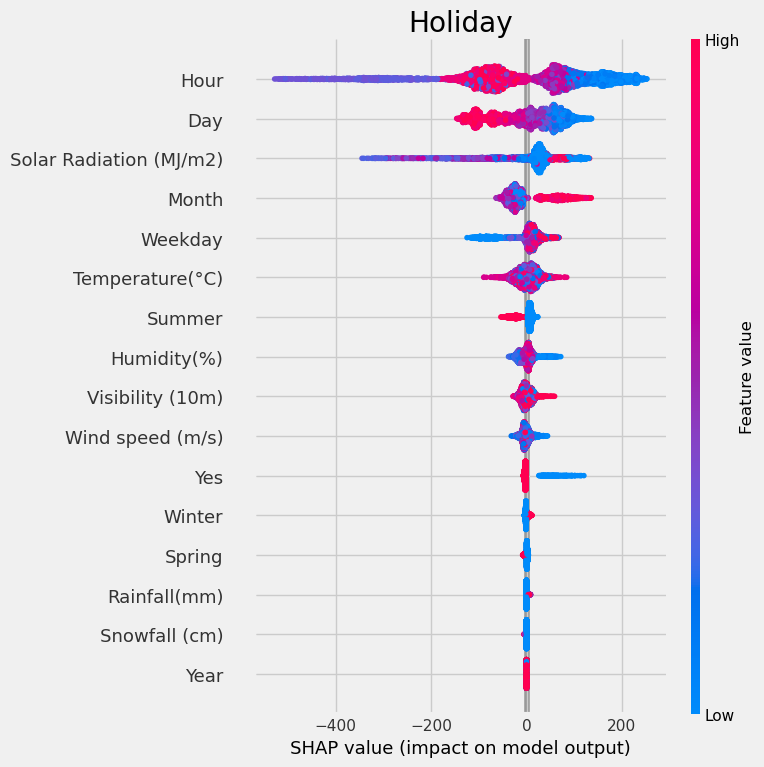

In [32]:
shap_xlearner = xlearner.get_shap_values(X = X, tau = xlearner_tau)
print(np.mean(np.abs(shap_xlearner['Holiday']), axis = 0))
xlearner.plot_shap_values(X = X, tau = xlearner_tau, features = feature_names)

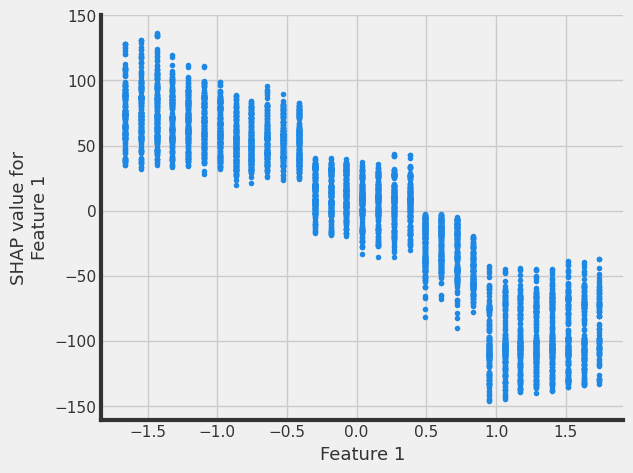

In [33]:
xlearner.plot_shap_dependence(treatment_group = 'Holiday', feature_idx = 1, X = X, tau = xlearner_tau,
                              interaction_idx = None, shap_dict = shap_xlearner)

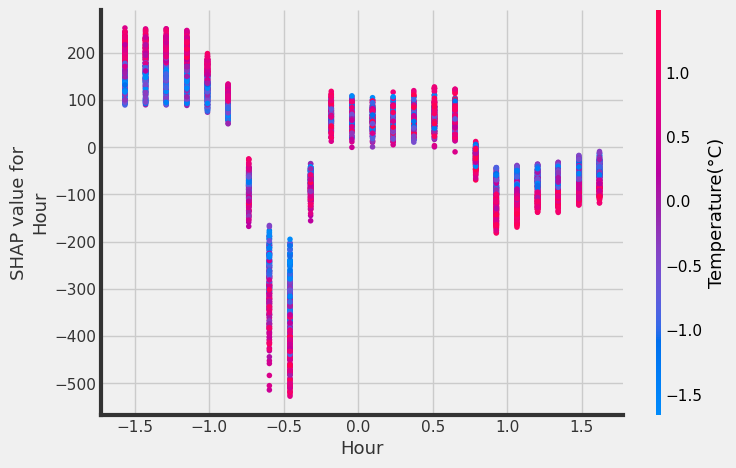

In [34]:
# Search for feature with greatest approximate interaction
xlearner.plot_shap_dependence(treatment_group = 'Holiday', feature_idx = 'Hour', X = X,
                              tau = xlearner_tau, interaction_idx = 'auto',
                              shap_dict = shap_xlearner, features = feature_names)

### BaseRRegressor

{'Holiday': Day                        0.154248
Temperature(°C)            0.147507
Hour                       0.138677
Weekday                    0.119639
Solar Radiation (MJ/m2)    0.114598
Humidity(%)                0.086725
Visibility (10m)           0.076527
Month                      0.059220
Wind speed (m/s)           0.054514
Spring                     0.021739
Summer                     0.010900
Rainfall(mm)               0.009248
Yes                        0.005054
Snowfall (cm)              0.000899
Winter                     0.000505
Year                       0.000000
dtype: float64}


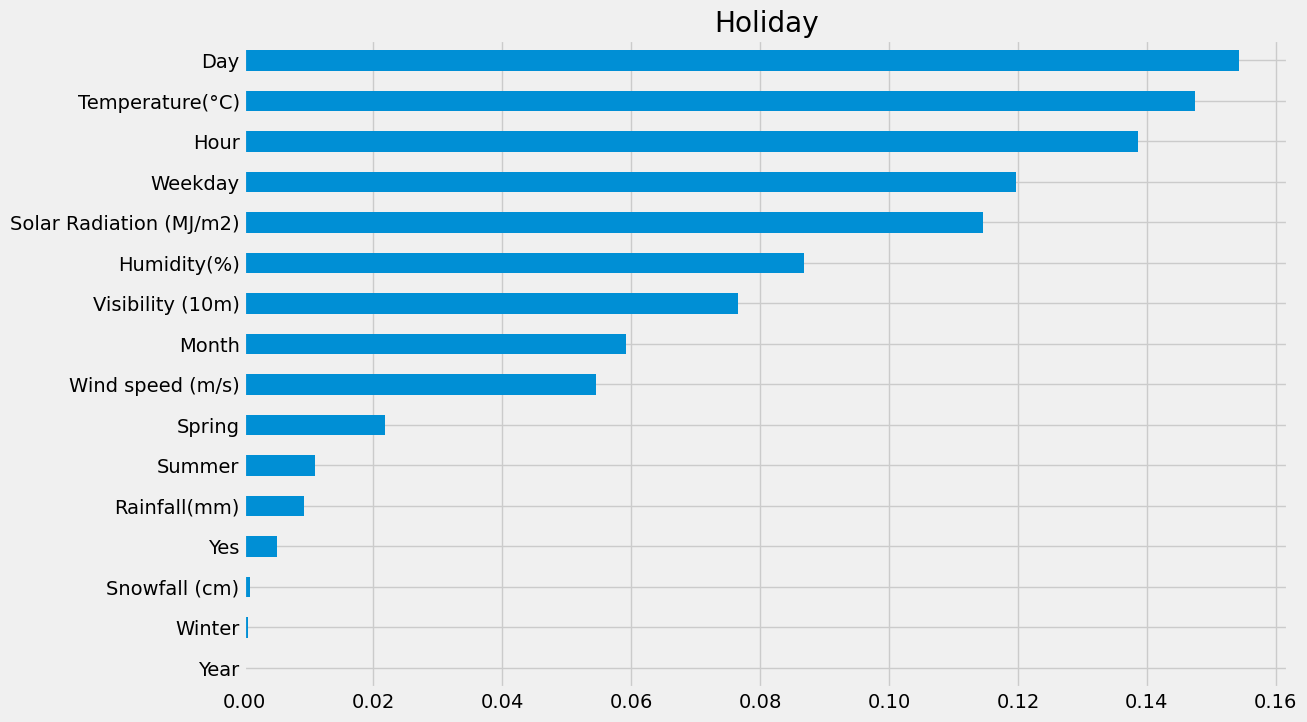

In [35]:
rlearner = BaseRRegressor(base_algo, control_name = 'control')
rlearner.estimate_ate(X, multi_treatment, y)
rlearner_tau = rlearner.fit_predict(X, multi_treatment, y)
print(rlearner.get_importance(X = X, tau = rlearner_tau, normalize = True, 
                        method = 'auto', features = feature_names))
rlearner.plot_importance(X = X, tau = rlearner_tau, normalize = True, 
                         method = 'auto', features = feature_names)

{'Holiday': Hour                       0.408742
Temperature(°C)            0.323826
Humidity(%)                0.282530
Day                        0.239910
Weekday                    0.193419
Spring                     0.190869
Solar Radiation (MJ/m2)    0.185617
Visibility (10m)           0.140690
Month                      0.086169
Wind speed (m/s)           0.064244
Yes                        0.024549
Summer                     0.024153
Rainfall(mm)               0.017097
Snowfall (cm)              0.002286
Winter                     0.000216
Year                       0.000000
dtype: float64}


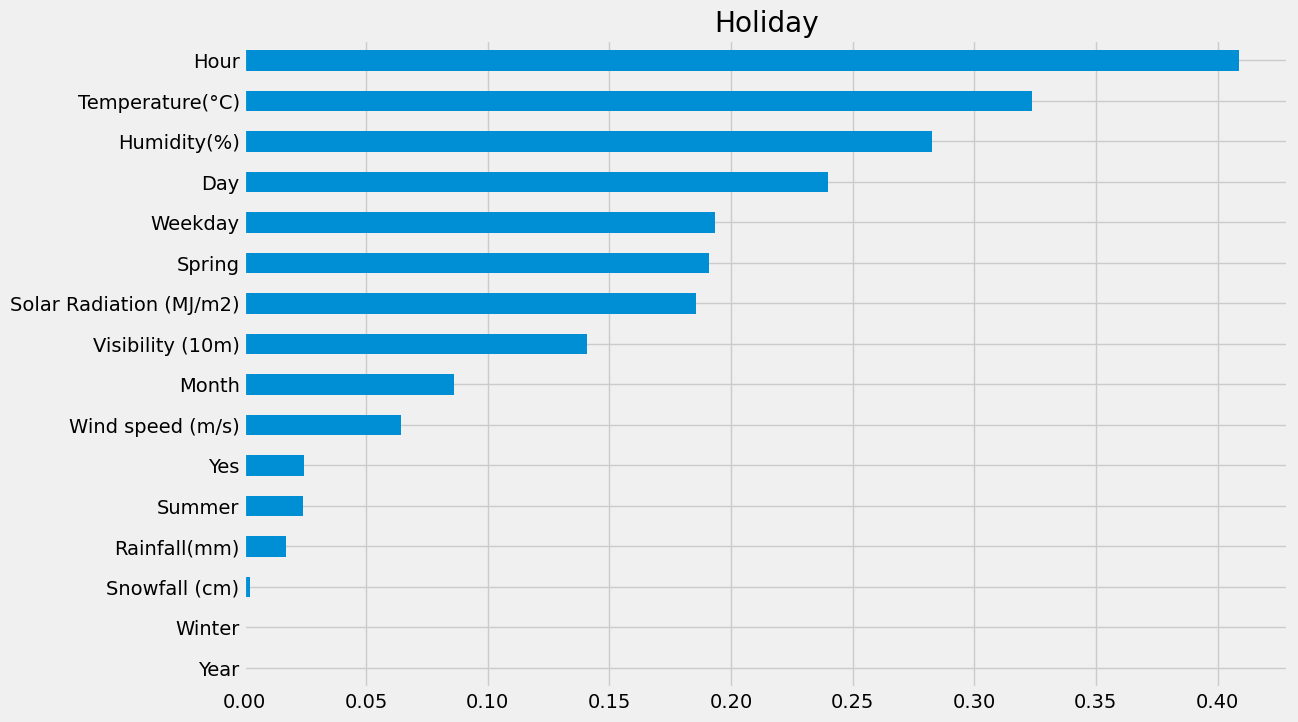

In [36]:
print(rlearner.get_importance(X = X, tau = rlearner_tau, method = 'permutation', 
                        features = feature_names, random_state = 119))
rlearner.plot_importance(X = X, tau = rlearner_tau, method = 'permutation', 
                         features = feature_names, random_state = 119)

[ 89.18452111  74.4725532   86.08783497   0.         175.43954704
 115.26825019  94.02780108  59.56496247  47.93426697 121.42240176
  12.82476268   3.80610407  77.09111581  35.66840235   4.2615116
  17.29952707]


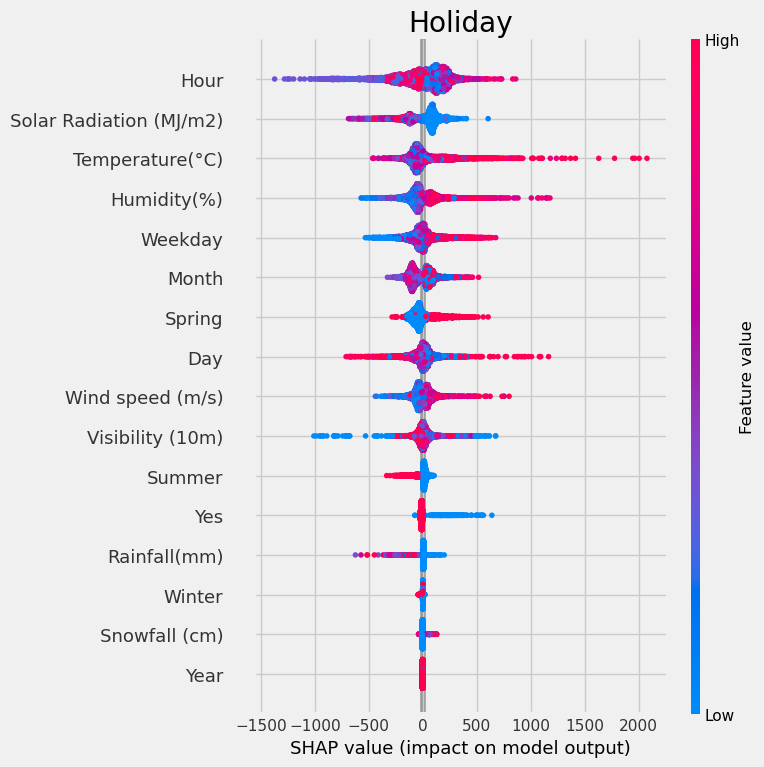

In [37]:
shap_rlearner = rlearner.get_shap_values(X = X, tau = rlearner_tau)
print(np.mean(np.abs(shap_rlearner['Holiday']), axis = 0))
rlearner.plot_shap_values(X = X, tau = rlearner_tau, features = feature_names)

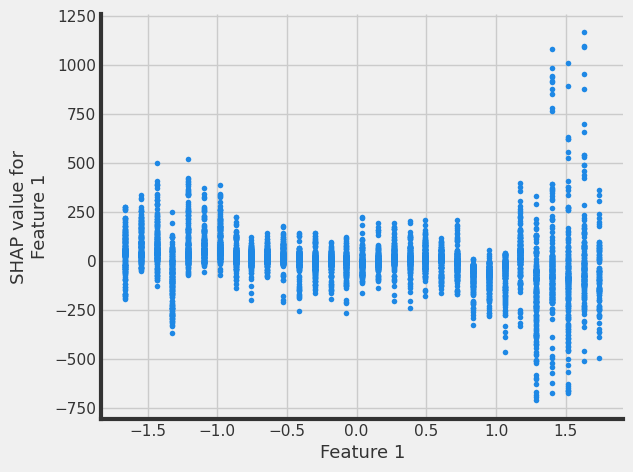

In [38]:
rlearner.plot_shap_dependence(treatment_group = 'Holiday', feature_idx = 1, X = X, tau = rlearner_tau,
                              interaction_idx = None, shap_dict = shap_rlearner)

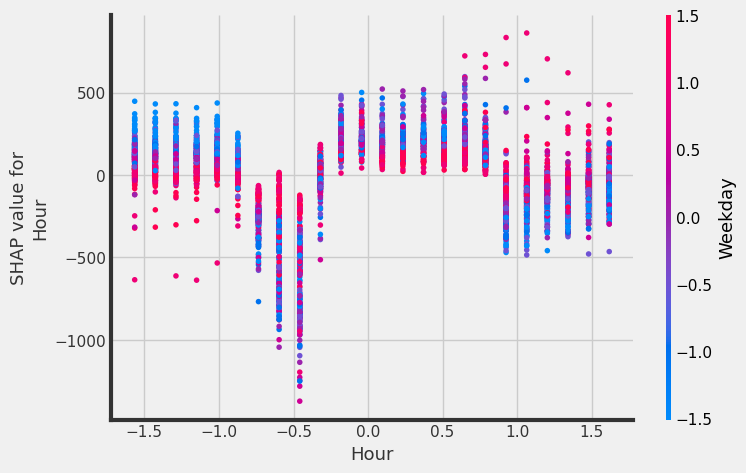

In [39]:
# Search for feature with greatest approximate interaction
rlearner.plot_shap_dependence(treatment_group = 'Holiday', feature_idx = 'Hour', X = X,
                              tau = rlearner_tau, interaction_idx = 'auto',
                              shap_dict = shap_rlearner, features = feature_names)

## Approach, Outcome, and Interpretation
Please see the attached PDF